# WEEK6 FINAL PROJECT

This is an augmenting notebook where I try to use transfer learning of ResNet.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pyplot as plt
from dask.array.image import imread
import cv2
from sklearn.model_selection import train_test_split

# for shuffling images
import random

import keras
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras import optimizers

from keras.callbacks import ModelCheckpoint,EarlyStopping


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

In [4]:
DATA_PATH = "kaggle"

INPUT_PATH = os.path.join(DATA_PATH, "input/state-farm-distracted-driver-detection")
IMAGES_PATH = os.path.join(INPUT_PATH, "imgs")
TEST_DIR = os.path.join(IMAGES_PATH, "test")
TRAIN_DIR = os.path.join(IMAGES_PATH, "train")

BASE_MODEL_PATH = os.path.join(DATA_PATH, "working", "model")

MODEL_PATH = os.path.join(BASE_MODEL_PATH, "resnet50")
OUTPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "output_csv_files")
INPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "input_csv_files")

if not os.path.exists(INPUT_CSV_FILES_DIR):
    os.makedirs(INPUT_CSV_FILES_DIR)
    print(f"Input CSV path created {INPUT_CSV_FILES_DIR}")
    
if not os.path.exists(OUTPUT_CSV_FILES_DIR):
    os.makedirs(OUTPUT_CSV_FILES_DIR)
    print(f"Output CSV path created {OUTPUT_CSV_FILES_DIR}")

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Model path created {MODEL_PATH}")

Input CSV path created kaggle/working/input_csv_files
Output CSV path created kaggle/working/output_csv_files
Model path created kaggle/working/model/resnet50


In [5]:
driver_details = pd.read_csv(os.path.join(INPUT_PATH, "driver_imgs_list.csv"),na_values='na')
driver_details.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
## Get all the images

train_image = []
image_label = []


for i in range(10):
    print(f'traversing C{i}')
    imgs = os.listdir(os.path.join(TRAIN_DIR, "c"+str(i)))
    for j in range(len(imgs)):
        img_name = os.path.join(TRAIN_DIR, "c"+str(i), imgs[j])
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

traversing C0
traversing C1
traversing C2
traversing C3
traversing C4
traversing C5
traversing C6
traversing C7
traversing C8
traversing C9


Instead of randomly picking images for training and validation, pick images based on driver

In [6]:
## Split the data into training and validation according to driver

driv_selected = ['p050', 'p015', 'p022', 'p056']

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [7]:
## Convert images to nparray. Encode/categorize Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18732, 224, 224, 3)


In [8]:
model_input = Input(shape = (224, 224, 3), name = 'Image_input')

#Get the RESNET weights and layers

model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_resnet50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
output_resnet50 = model_resnet50(model_input)


x = GlobalAveragePooling2D()(output_resnet50)
x = Dense(10, activation='softmax', name='predictions')(x)


final_model = Model(inputs=model_input, outputs=x)

final_model.summary()
 
final_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Image_input (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
filepath = os.path.join(MODEL_PATH,'resnet_sgd.keras')

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True),
earlystopper = EarlyStopping(monitor='accuracy', patience=7, verbose=1)
callbacks = [checkpointer, earlystopper]

img_data_gen = ImageDataGenerator(height_shift_range=0.5, width_shift_range = 0.5, zoom_range = 0.5, rotation_range=30)

data_generator = img_data_gen.flow(X_train, y_train, batch_size=64)

history = final_model.fit(data_generator, steps_per_epoch=int(len(X_train)/64), callbacks=callbacks, epochs=40, verbose=1, validation_data=(X_test, y_test))


Epoch 1/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1422 - loss: 2.4278
Epoch 1: val_loss improved from inf to 1.94930, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2381s 8s/step - accuracy: 0.1423 - loss: 2.4273 - val_accuracy: 0.3253 - val_loss: 1.9493
Epoch 2/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 43:03 9s/step - accuracy: 0.3281 - loss: 2.0094

2024-04-23 09:30:40.852273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 1.94930 to 1.94762, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 79s 240ms/step - accuracy: 0.3281 - loss: 2.0094 - val_accuracy: 0.3302 - val_loss: 1.9476
Epoch 3/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3399 - loss: 1.9340
Epoch 3: val_loss improved from 1.94762 to 1.27187, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2403s 8s/step - accuracy: 0.3401 - loss: 1.9336 - val_accuracy: 0.5764 - val_loss: 1.2719
Epoch 4/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 40:12 8s/step - accuracy: 0.3750 - loss: 1.6816

2024-04-23 10:12:02.087157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 1.27187 to 1.26485, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.3750 - loss: 1.6816 - val_accuracy: 0.5783 - val_loss: 1.2649
Epoch 5/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5345 - loss: 1.4905
Epoch 5: val_loss improved from 1.26485 to 0.83802, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2466s 8s/step - accuracy: 0.5346 - loss: 1.4902 - val_accuracy: 0.7164 - val_loss: 0.8380
Epoch 6/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 39:41 8s/step - accuracy: 0.5938 - loss: 1.2489

2024-04-23 10:54:29.735960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss improved from 0.83802 to 0.83459, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.5938 - loss: 1.2489 - val_accuracy: 0.7202 - val_loss: 0.8346
Epoch 7/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6224 - loss: 1.1991
Epoch 7: val_loss improved from 0.83459 to 0.66233, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2407s 8s/step - accuracy: 0.6224 - loss: 1.1989 - val_accuracy: 0.7847 - val_loss: 0.6623
Epoch 8/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 39:39 8s/step - accuracy: 0.6562 - loss: 1.0913

2024-04-23 11:35:55.521980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss improved from 0.66233 to 0.66086, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 76s 233ms/step - accuracy: 0.6562 - loss: 1.0913 - val_accuracy: 0.7860 - val_loss: 0.6609
Epoch 9/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6764 - loss: 1.0071
Epoch 9: val_loss improved from 0.66086 to 0.59398, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2407s 8s/step - accuracy: 0.6764 - loss: 1.0070 - val_accuracy: 0.8007 - val_loss: 0.5940
Epoch 10/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 41:28 9s/step - accuracy: 0.6406 - loss: 0.9653

2024-04-23 12:17:18.321496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss did not improve from 0.59398
292/292 ━━━━━━━━━━━━━━━━━━━━ 77s 237ms/step - accuracy: 0.6406 - loss: 0.9653 - val_accuracy: 0.7958 - val_loss: 0.5984
Epoch 11/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7228 - loss: 0.8657
Epoch 11: val_loss improved from 0.59398 to 0.53184, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2320s 8s/step - accuracy: 0.7229 - loss: 0.8656 - val_accuracy: 0.8267 - val_loss: 0.5318
Epoch 12/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 38:47 8s/step - accuracy: 0.7656 - loss: 0.8420

2024-04-23 12:57:15.349377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss did not improve from 0.53184
292/292 ━━━━━━━━━━━━━━━━━━━━ 77s 238ms/step - accuracy: 0.7656 - loss: 0.8420 - val_accuracy: 0.8253 - val_loss: 0.5339
Epoch 13/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7377 - loss: 0.7975
Epoch 13: val_loss improved from 0.53184 to 0.51126, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2310s 8s/step - accuracy: 0.7377 - loss: 0.7974 - val_accuracy: 0.8296 - val_loss: 0.5113
Epoch 14/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 38:14 8s/step - accuracy: 0.7969 - loss: 0.7091

2024-04-23 13:37:02.492851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 14: val_loss improved from 0.51126 to 0.51015, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 73s 224ms/step - accuracy: 0.7969 - loss: 0.7091 - val_accuracy: 0.8326 - val_loss: 0.5101
Epoch 15/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7621 - loss: 0.7239
Epoch 15: val_loss improved from 0.51015 to 0.47445, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2337s 8s/step - accuracy: 0.7622 - loss: 0.7239 - val_accuracy: 0.8491 - val_loss: 0.4744
Epoch 16/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 38:00 8s/step - accuracy: 0.8281 - loss: 0.5134

2024-04-23 14:17:12.345808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 0.47445
292/292 ━━━━━━━━━━━━━━━━━━━━ 73s 224ms/step - accuracy: 0.8281 - loss: 0.5134 - val_accuracy: 0.8475 - val_loss: 0.4756
Epoch 17/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7682 - loss: 0.6902
Epoch 17: val_loss improved from 0.47445 to 0.45461, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2368s 8s/step - accuracy: 0.7682 - loss: 0.6901 - val_accuracy: 0.8499 - val_loss: 0.4546
Epoch 18/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 46:26 10s/step - accuracy: 0.7656 - loss: 0.6674

2024-04-23 14:57:55.293517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 18: val_loss did not improve from 0.45461
292/292 ━━━━━━━━━━━━━━━━━━━━ 86s 262ms/step - accuracy: 0.7656 - loss: 0.6674 - val_accuracy: 0.8486 - val_loss: 0.4568
Epoch 19/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7843 - loss: 0.6402
Epoch 19: val_loss improved from 0.45461 to 0.44516, saving model to resnet_sgd.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2374s 8s/step - accuracy: 0.7843 - loss: 0.6402 - val_accuracy: 0.8602 - val_loss: 0.4452
Epoch 20/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 37:09 8s/step - accuracy: 0.8281 - loss: 0.5623

2024-04-23 15:38:53.390862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_loss did not improve from 0.44516
292/292 ━━━━━━━━━━━━━━━━━━━━ 73s 223ms/step - accuracy: 0.8281 - loss: 0.5623 - val_accuracy: 0.8605 - val_loss: 0.4484
Epoch 21/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8063 - loss: 0.5916
Epoch 21: val_loss did not improve from 0.44516
292/292 ━━━━━━━━━━━━━━━━━━━━ 2348s 8s/step - accuracy: 0.8063 - loss: 0.5916 - val_accuracy: 0.8486 - val_loss: 0.4606
Epoch 22/40
  1/292 ━━━━━━━━━━━━━━━━━━━━ 36:43 8s/step - accuracy: 0.8125 - loss: 0.5283

2024-04-23 16:19:13.647671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 22: val_loss did not improve from 0.44516
292/292 ━━━━━━━━━━━━━━━━━━━━ 72s 223ms/step - accuracy: 0.8125 - loss: 0.5283 - val_accuracy: 0.8510 - val_loss: 0.4523
Epoch 23/40
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8089 - loss: 0.5657
Epoch 23: val_loss did not improve from 0.44516
292/292 ━━━━━━━━━━━━━━━━━━━━ 2322s 8s/step - accuracy: 0.8089 - loss: 0.5657 - val_accuracy: 0.8502 - val_loss: 0.4560
Epoch 23: early stopping


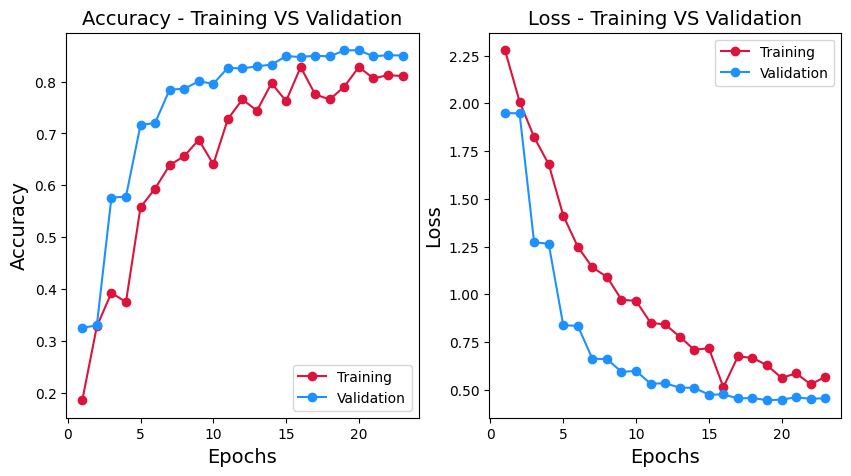

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training')
axes[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Validation')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('Accuracy - Training VS Validation', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training')
axes[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Validation')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('Loss - Training VS Validation', fontsize = 14)
axes[1].legend(loc = 'best')

In [10]:
test_image = []

files = os.listdir(TEST_DIR)
for i in range(len(files)):
    img = cv2.imread(os.path.join(TEST_DIR, files[i]))
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    
final_model.load_weights(filepath)

test_image = np.array(test_image).reshape(-1,224,224,3)
prediction = final_model.predict(test_image)

2492/2492 ━━━━━━━━━━━━━━━━━━━━ 1474s 591ms/step


In [11]:
prediction.shape

(79726, 10)

In [12]:
df = pd.DataFrame(columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(files)):
    new_row = {
        "img":files[i], 
        'c0':prediction[i][0],
        'c1':prediction[i][1],
        'c2':prediction[i][2],
        'c3':prediction[i][3],
        'c4':prediction[i][4],
        'c5':prediction[i][5],
        'c6':prediction[i][6],
        'c7':prediction[i][7],
        'c8':prediction[i][8],
        'c9':prediction[i][9]
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
df.to_csv(os.path.join("csv_files","resnet_sgd_1.csv"),index=False)

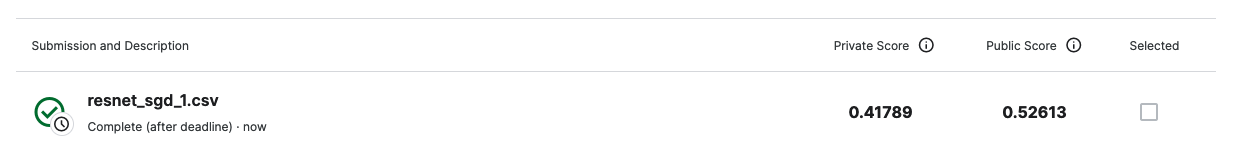